## Notebook for interpreting ML through SHAP

#### Model: LightGBM

#### Splitting: Random

**Created on 21st September, 2022; remodified on 14th February, 2024**

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
#import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
import shap

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/ionic-conductivity_2.1/dataset_v2.0/common-log-output/lgbm_trials/stratified-split-2-cv_2
total 11888
-rw-------@ 1 riteshk  staff   104320 Feb 13 19:28 split_dataset_strat2_cond_sl.ipynb.ipynb
-rw-r--r--  1 riteshk  staff  2722289 Feb 13 19:28 train_qsar_stratII_cond.csv
-rw-r--r--  1 riteshk  staff   343456 Feb 13 19:28 val_qsar_stratII_cond.csv
-rw-r--r--  1 riteshk  staff   342499 Feb 13 19:28 test_qsar_stratII_cond.csv
-rw-r--r--  1 riteshk  staff    58035 Feb 14 01:10 ood_qsar_fgrp_cond.csv
-rw-r--r--  1 riteshk  staff   302546 Feb 14 01:38 lgbm_cond_strat2_fold_1.sav
-rw-r--r--  1 riteshk  staff   307888 Feb 14 01:38 lgbm_cond_strat2_fold_2.sav
-rw-r--r--  1 riteshk  staff   323359 Feb 14 01:38 lgbm_cond_strat2_fold_3.sav
-rw-r--r--  1 riteshk  staff   309394 Feb 14 01:38 lgbm_cond_strat2_fold_4.sav
-rw-r--r--  1 riteshk  staff   297555 Feb 14 01:38 lgbm_cond_strat2_fold_5.sav
-rw---

In [3]:
df_all = pd.read_csv('../random-split/all_qsar_cond.csv')
train_df = pd.read_csv('train_qsar_stratII_cond.csv')
val_df = pd.read_csv('val_qsar_stratII_cond.csv')
test_df = pd.read_csv('test_qsar_stratII_cond.csv')
df_all.drop(columns='fr_func_grp_20_salt', inplace=True)
train_df.drop(columns='fr_func_grp_20_salt', inplace=True)
val_df.drop(columns='fr_func_grp_20_salt', inplace=True)
test_df.drop(columns='fr_func_grp_20_salt', inplace=True)
train_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log,conductivity_log_bin
0,CC1COC(=O)O1.O=C1OCCO1,CC[N+](CC)(CC)CC.F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,1,16,0,144.964181,0.190698,60.000,0.660961,5
1,CC1COC(=O)O1.CCOC(=O)OCC,[B-](F)(F)(F)F.CC[N+](CC)(CC)CC,0,0,0,0,0,0,0,0,...,0,0,1,14,0,87.003467,1.304688,60.000,1.379852,6
2,CC1COC(=O)O1.CCOC(=O)OCC,[B-](F)(F)(F)F.CC[N+](CC)(CC)CC,0,0,0,0,0,0,0,0,...,0,0,1,14,0,87.003467,1.154882,10.000,0.982081,5
3,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,14,0,186.969171,0.240000,29.400,0.598077,5
4,COCCOC.O=C1CCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.081500,25.000,0.504063,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8151,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.230000,49.200,0.990060,5
8152,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F.COCCOCCOC.COCCOCCOC,0,0,0,0,0,0,0,0,...,0,0,0,26,0,144.964181,0.273190,25.000,0.627673,5
8153,CC1COC(=O)O1,[Li+].[B-](F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,6,0,87.003467,0.000947,25.000,-1.582382,3
8154,CC1COC(=O)O1.CCOC(=O)OC.COC(=O)OC,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,14,0,186.969171,0.800000,-20.000,0.158661,5


In [4]:
X_train = train_df.iloc[:,2:-2]
y_train = train_df.iloc[:,-2]

X_test = test_df.iloc[:,2:-2]
y_test = test_df.iloc[:,-2]

X_val = val_df.iloc[:,2:-2]
y_val = val_df.iloc[:,-2]

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)

In [5]:
pred_array = []

lgbm_models = []
for i in range(1,6):
    filename = f'./lgbm_cond_strat2_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    lgbm_models.append(loaded_model)
    y_pred_test = loaded_model.predict(X_test_)
    pred_array.append(y_pred_test)

y_l = x_l = np.linspace(-6, -0.5, 100)
y_pred_ood_avg = np.mean(pred_array, axis=0)
y_pred_ood_avg = np.ravel(y_pred_ood_avg)
y_pred_ood_std = np.std(pred_array, axis=0)
y_pred_ood_std = np.ravel(y_pred_ood_std)
rmse_ood = np.sqrt(mean_squared_error(y_test, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_test, y_pred_ood_avg); r2_ood = r2_score(y_test, y_pred_ood_avg)
print(f"Avg RMSE test: {rmse_ood}, Avg MAE test: {mae_ood}, Avg R2 test: {r2_ood}")

Avg RMSE test: 0.18581331611615554, Avg MAE test: 0.10598035958027592, Avg R2 test: 0.9380304677487615


In [17]:
# model = lgbm_models[2]

In [7]:
X_all = df_all.iloc[:,2:-1]
X_all

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,fr_func_grp_39_salt,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,1.0,25.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,1.0,25.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,1.0,25.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,1.0,25.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,2,279.917842,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,8,0,144.964181,0.1,30.0
10192,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,8,0,144.964181,0.5,30.0
10193,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,8,0,144.964181,1.0,30.0
10194,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,8,0,144.964181,1.5,30.0


In [18]:
# explainerModel = shap.TreeExplainer(model = model)
# shap_values = explainerModel.shap_values(X_all)

In [ ]:
# ## save the SHAP values
# cols_X = X_all.columns
# cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
# shap_df = pd.DataFrame(shap_values)
# shap_df.columns = cols_shap
# # shap_df.to_csv('shap_values_all.csv', index=False)
# shap_df

In [ ]:
# comb_df = pd.concat([X_all,shap_df], axis=1)
# comb_df['conductivity_log'] = df_all['conductivity_log']
# comb_df

In [22]:
shap_values_all = []
for i in range(5):
    model = lgbm_models[i] ## models trained on each fold
    explainerModel = shap.TreeExplainer(model = model)
    shap_values = explainerModel.shap_values(X_all)
    shap_values_all.append(shap_values)

shap_values_all = np.array(shap_values_all)
shap_values_all_mean = np.mean(shap_values_all, axis=0) ## average SHAP values across all models
cols_X = X_all.columns
cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
shap_df = pd.DataFrame(shap_values_all_mean)
shap_df.columns = cols_shap
# shap_df.to_csv('shap_values_all.csv', index=False)

comb_df = pd.concat([X_all,shap_df], axis=1)
comb_df['conductivity_log'] = df_all['conductivity_log']
comb_df

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,shap_fr_func_grp_40_salt,shap_fr_func_grp_41_salt,shap_fr_func_grp_42_salt,shap_fr_func_grp_43_salt,shap_num_heavy_atom_salt,shap_num_rot_bond_salt,shap_mw_salt,shap_conc_salt,shap_temperature,conductivity_log
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000488,-0.000439,-0.012888,-0.343850,-0.024447,-0.257629,0.164619,1.148916,1.068186
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000488,-0.000442,-0.012834,-0.338362,-0.024447,-0.259890,0.163335,1.138515,0.770852
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000488,-0.000434,-0.012834,-0.342621,-0.024447,-0.258196,0.164781,1.140959,0.732394
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000488,-0.000434,-0.012834,-0.342621,-0.024447,-0.258196,0.164781,1.140959,0.812913
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000768,-0.000435,-0.009171,-0.317134,0.073030,-0.203032,0.211374,1.243761,0.322219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,0,0,0,0,0,0,0,0,0,2,...,0.0,0.000488,-0.000433,-0.008261,-0.339171,-0.025161,-0.267749,0.166214,1.104655,0.672098
10192,0,0,0,0,0,0,0,0,0,2,...,0.0,0.000488,-0.000433,-0.008261,-0.338040,-0.025057,-0.269227,0.215759,1.103255,1.139879
10193,0,0,0,0,0,0,0,0,0,2,...,0.0,0.000488,-0.000433,-0.008261,-0.334634,-0.024860,-0.264900,0.169621,1.128258,1.204120
10194,0,0,0,0,0,0,0,0,0,2,...,0.0,0.000488,-0.000433,-0.008261,-0.335065,-0.025791,-0.259279,0.066086,1.158911,1.167317


**SHAP summary plot**

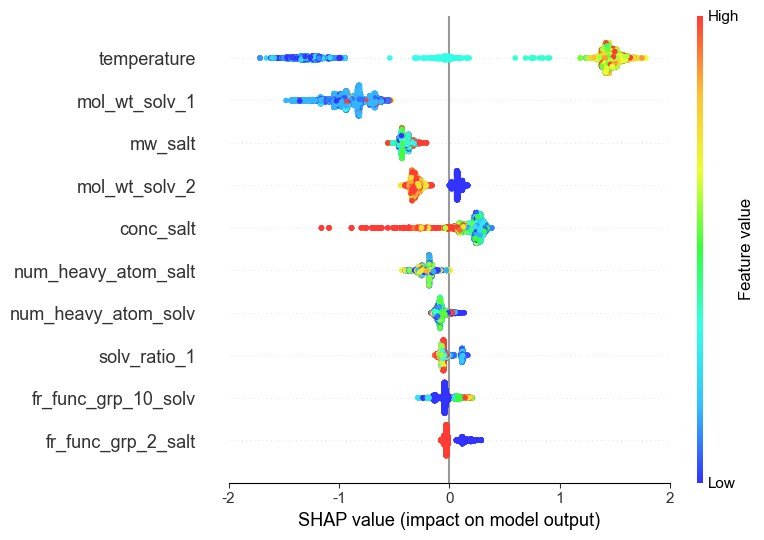

In [45]:
## Color scheme according to origin plots
c1 = '#3333FF'; c1 = mcolors.to_rgb(c1)
c2 = '#33C2FF'; c2 = mcolors.to_rgb(c2)
c3 = '#33FFE8'; c3 = mcolors.to_rgb(c3)
c4 = '#33FF3B'; c4 = mcolors.to_rgb(c4)
c5 = '#E9FF33'; c5 = mcolors.to_rgb(c5)
c6 = '#FFC133'; c6 = mcolors.to_rgb(c6)
c7 = '#FF3B33'; c7 = mcolors.to_rgb(c7)
ax = plt.gca()
# cmap1_or = mcolors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = mcolors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red
shap.summary_plot(shap_values, X_all, max_display=10, show=False, cmap=cmap1)
ax.set_xticks([-2,-1,0,1,2])
ax.set_xticklabels([-2,-1,0,1,2])
plt.savefig('shap_lgbm_strat2_summary.eps', dpi=300)

**SHAP dependence plots**

In [46]:
comb_df = comb_df.sort_values(by=['conc_salt'], ascending=True)

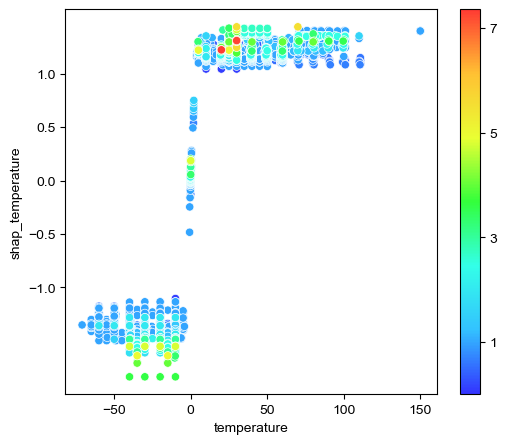

In [35]:
## For temperature (whole range)
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='temperature', y='shap_temperature', data=comb_df, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-1, -0.5, 0.0, 0.5, 1.0])
ax.figure.colorbar(sm, ticks=[1, 3, 5, 7])
plt.savefig('shap_lgbm_strat2_temperature_complete_dependence.eps', dpi=300)

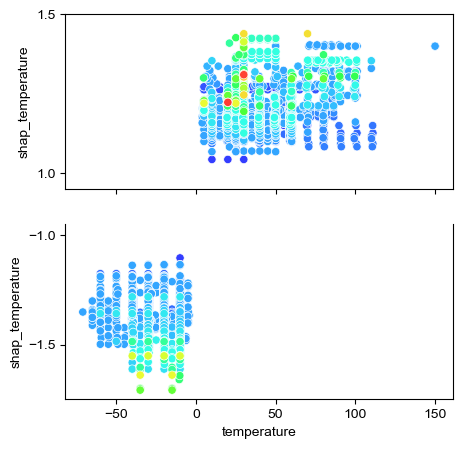

In [50]:
## For temperature with a break
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
ax1 = sns.scatterplot(x='temperature', y='shap_temperature', data=comb_df, hue='conc_salt', palette=cmap1, ax=ax1)
ax2 = sns.scatterplot(x='temperature', y='shap_temperature', data=comb_df, hue='conc_salt', palette=cmap1, ax=ax2)
# ax1.set_ylim(1, 3.7)
# ax2.set_ylim(-5, -1)
ax1.set_ylim(0.95, 1.5)
ax2.set_ylim(-1.75, -0.95)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)


ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_yticks([1, 1.5])
ax2.set_yticks([-1.5, -1])
plt.savefig('shap_lgbm_strat2_temperature_break_dependence.eps', dpi=300)

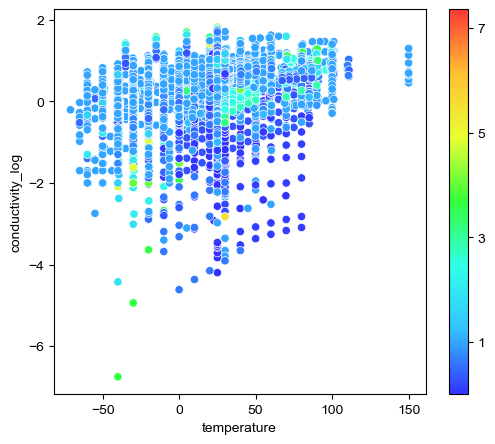

In [37]:
# ## scatter plot for temperature
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='temperature', y='conductivity_log', data=df_all, hue='conc_salt', palette=cmap1)
norm = plt.Normalize(df_all['conc_salt'].min(), df_all['conc_salt'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-6, -4, -2, 0, 2])
ax.figure.colorbar(sm, ticks=[1, 3, 5, 7])
plt.savefig('actual_temperature_dependence_common_log.eps', bbox_inches='tight', dpi=300)

In [38]:
comb_df = comb_df.sort_values(by=['temperature'], ascending=True)

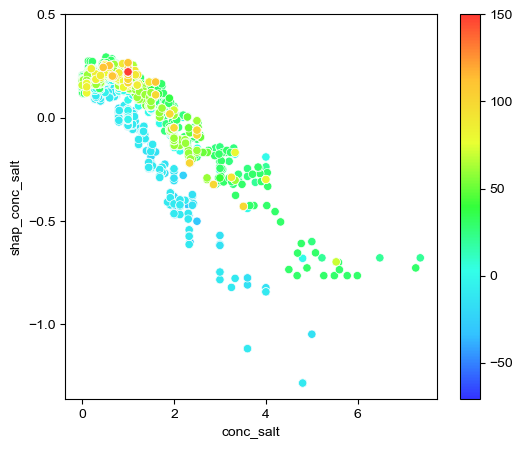

In [39]:
## For salt concentration (whole range)
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='conc_salt', y='shap_conc_salt', data=comb_df, hue='temperature', palette=cmap1)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-1, -0.5, 0, 0.5])
ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150])
plt.savefig('shap_lgbm_strat2_conc_salt_complete_dependence.eps', dpi=300)

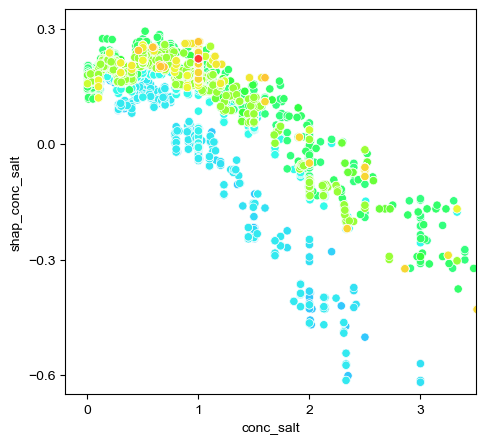

In [40]:
## Also for SHAP dependence plot: conc_salt (reduced range)
fig, ax = plt.subplots(figsize=(5.3, 5))
ax = sns.scatterplot(x='conc_salt', y='shap_conc_salt', data=comb_df, hue='temperature', palette=cmap1)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# plt.plot(x_smooth, y_smooth_1, color='black', linewidth=2) ## don't use it
# plt.plot(x_smooth, y_smooth_2, color='gray', linewidth=2) 

# plt.plot(x_1_, y_1_, color=c1, linewidth=2, linestyle='--') ## from 3rd degree polynomial fit (not using it)
# plt.plot(x_2_, y_2_, color=c7, linewidth=2, linestyle='--') 

# plt.plot(x_1_, y_1_, color=c1, linewidth=2, linestyle='--') ## from 4th degree polynomial fit
# plt.plot(x_2_, y_2_, color=c7, linewidth=2, linestyle='--')
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_xlim([-0.2, 3.5])
ax.set_ylim([-0.65, 0.35])
ax.set_yticks([-0.6, -0.3, 0.0, 0.3])
ax.set_xticks([0, 1, 2, 3])
# ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150]) ## turn off to match size with temperature subplot
plt.savefig('shap_lgbm_strat2_conc_salt_reduced_dependence.eps', dpi=300)

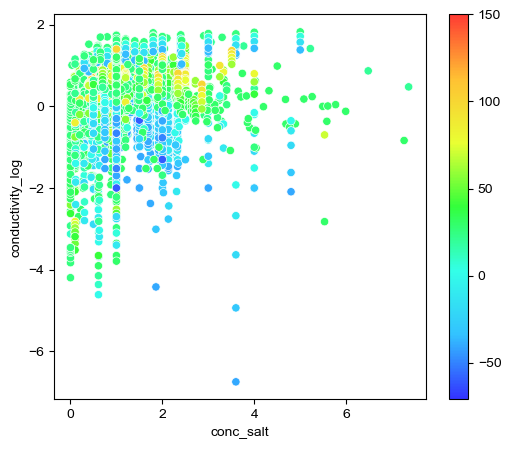

In [41]:
fig, ax = plt.subplots(figsize=(6, 5))
# ## Color scheme according to origin plots
# c1 = '#3333FF'; c1 = matplotlib.colors.to_rgb(c1)
# c2 = '#33C2FF'; c2 = matplotlib.colors.to_rgb(c2)
# c3 = '#33FFE8'; c3 = matplotlib.colors.to_rgb(c3)
# c4 = '#33FF3B'; c4 = matplotlib.colors.to_rgb(c4)
# c5 = '#E9FF33'; c5 = matplotlib.colors.to_rgb(c5)
# c6 = '#FFC133'; c6 = matplotlib.colors.to_rgb(c6)
# c7 = '#FF3B33'; c7 = matplotlib.colors.to_rgb(c7)
# cmap1_or = matplotlib.colors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
# cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red
ax = sns.scatterplot(x='conc_salt', y='conductivity_log', data=df_all, hue='temperature', palette=cmap1)
# cbar = plt.colorbar(fig)
# cbar.set_label('Temperature ($\degree$C)', rotation=270, labelpad=15)
norm = plt.Normalize(df_all['temperature'].min(), df_all['temperature'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-6, -4, -2, 0, 2])
ax.figure.colorbar(sm, ticks=[-50, 0, 50, 100, 150])
plt.savefig('actual_conc_salt_dependence_common_log.eps', dpi=300)